In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import imp
import sys
sys.path.append('/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
from elephant.spike_train_surrogates import * 
from elephant.statistics import mean_firing_rate, cv, isi

from quantities import Hz, ms
from scipy.linalg import eigh
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

URLError: <urlopen error [Errno 110] Connection timed out>

#### Load functions for validation tools and visualization

In [2]:
%%capture
dist = imp.load_source('*', './validation/dist.py')
matstat = imp.load_source('*', './validation/matrix.py')
testdata = imp.load_source('*', './validation/test_data.py')
vizi = imp.load_source('*', '../INM6/Tasks/viziphant/plots/generic.py')

data_path = '/home/robin/Projects/ValidationTools'
nest_path = data_path + "/sim_data/NEST_data"
spinnaker_path = data_path + "/sim_data/SpiNNaker_data"

# Number of spiketrains:
N = 100

#### Load spiketrains from simulation

In [ ]:
spiketrain_list_1 = testdata.load_data(nest_path, ['spikes_L4'], N)[0][0]

spiketrain_list_2 = testdata.load_data(spinnaker_path, ['spikes_L4'], N)[0][0]

#### ...or generate custom spiketrains

In [8]:
spiketrain_list_1 = testdata.test_data(size=N, 
                                       corr=.1, 
                                       t_stop=500*ms, 
                                       rate=100*Hz, 
                                       assembly_sizes=[13],
                                       method="CPP", 
                                       bkgr_corr=0.00,
                                       shuffle_seed=42)

spiketrain_list_2 = testdata.test_data(size=N, 
                                       corr=[.2,.1,.1], 
                                       t_stop=500*ms, 
                                       rate=100*Hz, 
                                       assembly_sizes=[13,10,5],
                                       method="CPP", 
                                       bkgr_corr=0.01,
                                       shuffle_seed=42)

#### Rasterplots

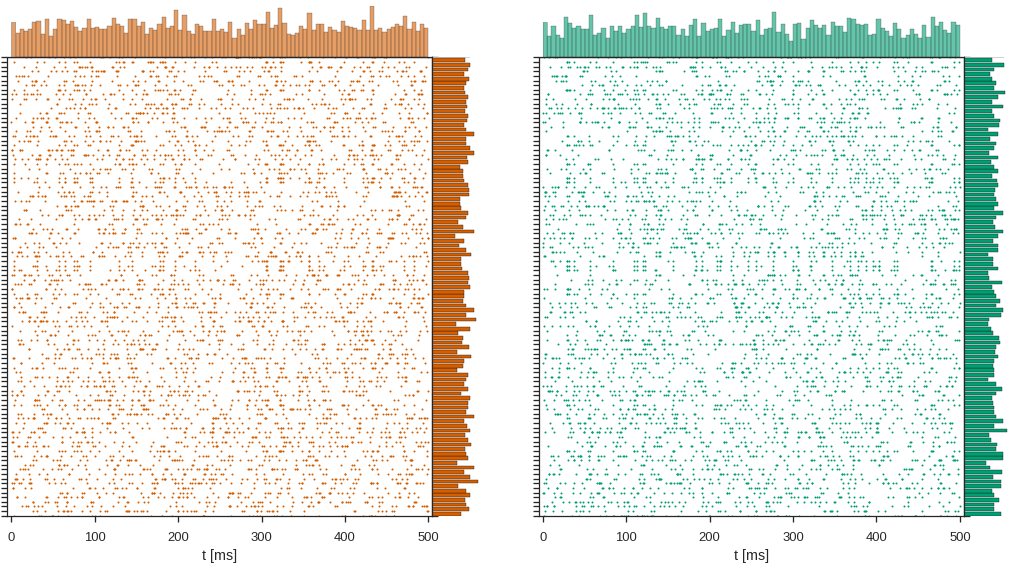

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
fig.tight_layout()

__ = vizi.rasterplot(spiketrain_list_1, ax=ax[0], palette=(['r']))
__ = vizi.rasterplot(spiketrain_list_2, ax=ax[1], palette=(['g']))

### Compare distributions 
##### of CVs, firing rates, correlation coefficients, ...

In [42]:
def func(sts):
    return matstat.corr_matrix(sts).flatten() # cv(isi(x)), mean_firing_rate(x)
    
dist_sample_1 = func(spiketrain_list_1)

dist_sample_2 = func(spiketrain_list_2)

#### Kullback-Leibler Divergence

$$ D_\mathrm{KL}(P||Q) =\sum_{i} P(i) \log_2 \frac{P(i)}{Q(i)} = H(P,Q) - H(P)$$
$ $

The KL-Divergence is a measure of difference between two distribution based on entropy.

When $P$ can be regarded as reference, $D_\mathrm{KL}$ is the amount of information lost when substituting $Q$ for $P$. Consequently this measure is asymetric.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
DKL, DKL_inv = dist.KL_test(dist_sample_1, dist_sample_2, ax=ax, bins=100, excl_zeros=True, xlabel='CC')

#### Kolmogorov-Smirnov Distance

$$ D_\mathrm{KS} = \sup | \hat{P}(x) - \hat{Q}(x) | $$
$ $

The KS-Distance measures the maximal vertical distance of the cumulative distributions $\hat{P}$ and $\hat{Q}$. This is a sensitive tool for detecting differences in mean, variance or distribution type. But it can't well detect deviations in the tails of the distributions. A possibily more powerful alternative would be the Cramér-von-Mises Test.

$ $

The null hypothesis that the underlying distributions are identical is rejected when the $D_\mathrm{KS}$ statistic is larger than a critical value $D_\alpha$ or equivalently when the correponding p-value is less than the signficance level $\alpha$.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
DKS, p = dist.KS_test(dist_sample_1, dist_sample_2, ax=ax)

#### Mann-Whitney U Test

$$ U_i = R_i - \frac{n_i(n_i + 1)}{2}\\ U = min(U_1,U_2) $$

$R_i$: rank sum

$n_i$: sample size

$ $

The Mann-Whitney U is a rank statistic which test the null hypothesis that a random value of sample 1 is equally likely to be larger or a smaller value than a randomly chosen value of sample 2.

$ $

The $U_i$ statistic is in the range of $[0,n_1 n_2]$, and the $U=min(U_1,U_2)$ statistic is in the range of $[0,\frac{n_1 n_2}{2}]$.

$ $

For sample sizes $>20$ $U$ follows approximately a normal distribution. With this assumption a p-value can be inferred. The null hypothesis is consequently rejected when the p-value is less than the significance level.


Mann-Whitney-U-Test
	length 1 = 10000 	 length 2 = 10000
	U = 50133452.00   	 p value = 0.74


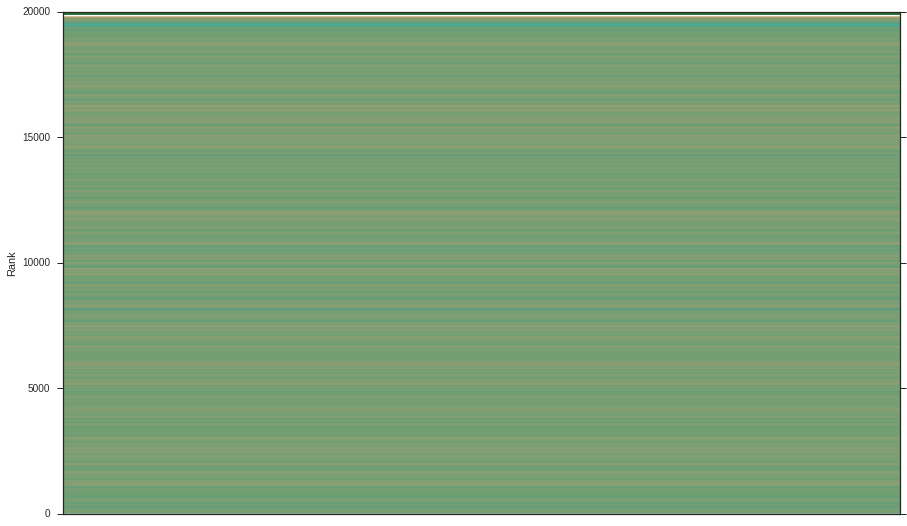

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,9))
U, p = dist.MWU_test(dist_sample_1[:], dist_sample_2[:], ax=ax, excl_nan=True)

### Compare the correlation matrices

#### Heatmap

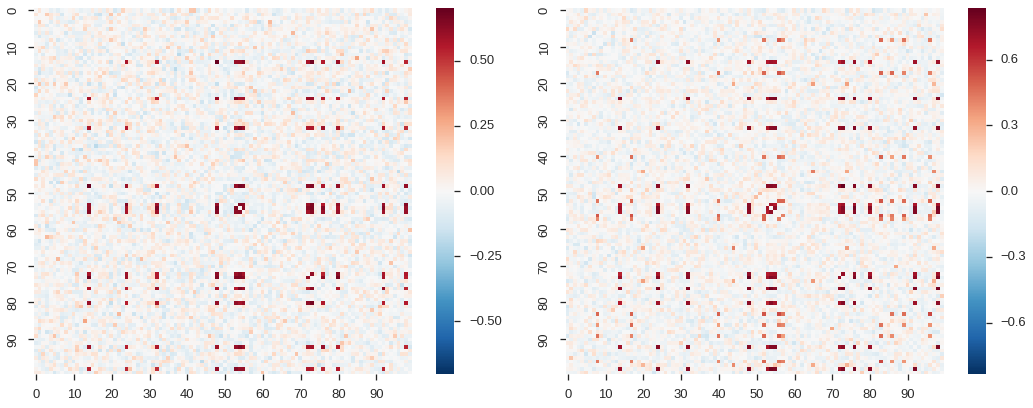

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

corr_matrix_1 = matstat.corr_matrix(spiketrain_list_1)
corr_matrix_2 = matstat.corr_matrix(spiketrain_list_2)

matstat.plot_matrix(corr_matrix_1, ax[0], remove_autocorr=True)
matstat.plot_matrix(corr_matrix_2, ax[1], remove_autocorr=True)

#### Eigenvalue distribution


Eigenvalue distribution:
	EW_max = 8.58
	EW_min = 0.11

Redundancy = 0.10 


Eigenvalue distribution:
	EW_max = 10.10
	EW_min = 0.08

Redundancy = 0.12 



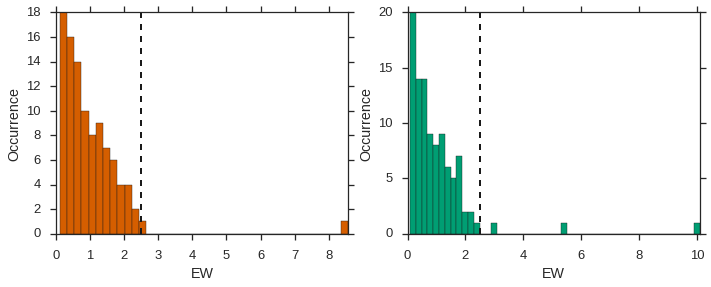

In [24]:
EWs_1, EVs_1 = eigh(corr_matrix_1)
EWs_2, EVs_2 = eigh(corr_matrix_2)

# Generate surrogates as reference
#def generate_ref(spiketrain_list):
#    surrogate_spiketrain_list = testdata.generate_surrogates(spiketrain_list, 
#                                                             dither_spikes, #_train, 
#                                                             dither=10*ms) #shift
#    surrogate_corr_matrix = matstat.corr_matrix(surrogate_spiketrain_list)
#    return eigh(surrogate_corr_matrix)[0]

EWmax_mean, EWmax_std = matstat.estimate_largest_eigenvalue(N=100,
                                                            trials=1,
                                                            t_stop=500,
                                                            rate=100,
                                                            bins=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
fig.tight_layout()
__ = matstat.eigenvalue_distribution(EWs_1, ax[0], 
                                     #reference_EWs=generate_ref(spiketrain_list_1),
                                     reference_EW_max=EWmax_mean + 2*EWmax_std,
                                     bins=int(max(EWs_1))*5, color='r')
__ = matstat.redundancy(EWs_1)

__ = matstat.eigenvalue_distribution(EWs_2, ax[1], 
                                     #reference_EWs=generate_ref(spiketrain_list_2),
                                     reference_EW_max=EWmax_mean + 2*EWmax_std,
                                     bins=int(max(EWs_2))*5, color='g')
__ = matstat.redundancy(EWs_2)

#### Eigenvalue spectra


Significance Test:
	Method: SCREE 
	4 of 100 eigenvalues are significant

Princial components:
	0: 8.58
	1: 2.48
	2: 2.36
	3: 2.23


Significance Test:
	Method: broken-stick 
	2 of 100 eigenvalues are significant

Princial components:
	0: 10.10
	1: 5.38



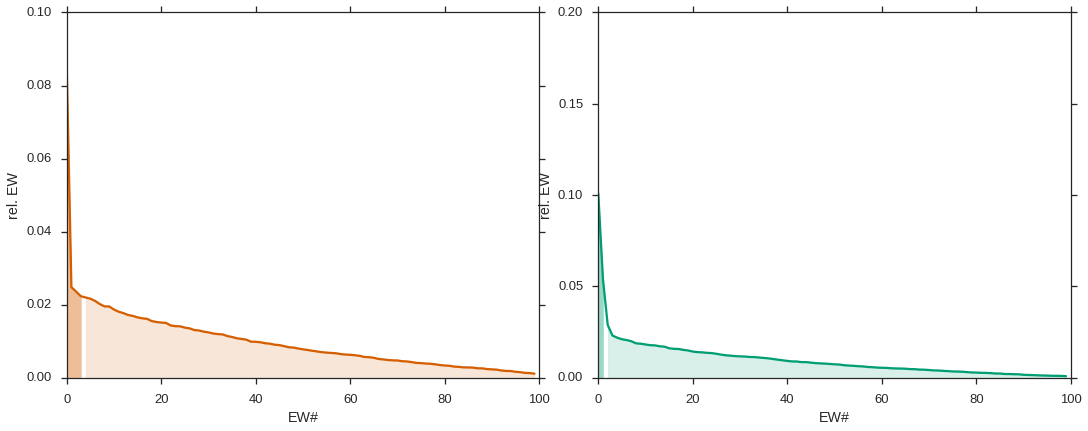

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

pc_nbr_1 = matstat.eigenvalue_spectra(EWs_1, method='SCREE', ax=ax[0], color='r')
pc_nbr_2 = matstat.eigenvalue_spectra(EWs_2, method='broken-stick', ax=ax[1], color='g')

#### Show eigenvectors

In [13]:
if N < 17:
    colormap = [37,37,30,34,32,31,33,36,35] + [47,40,44,42,41,43,46,45]
    matstat.print_eigenvectors(EVs_1, EWs_1, pc_nbr_1, colormap=colormap)
    matstat.print_eigenvectors(EVs_2, EWs_2, pc_nbr_2, colormap=colormap)

#### Angles between eigenspaces

In [14]:
nbr_of_pcs = min(pc_nbr_1, pc_nbr_2)
_ = matstat.EV_angles(EVs_1[:, -nbr_of_pcs:], EVs_2[:, -nbr_of_pcs:])


Angles between the eigenvectors
	10.33°
	62.38°

Angle between eigenspaces
	64.95°


#### Detect Assemblies

In [22]:
print "\033[36mSample 1\033[0m\n"
__, corr_order_1 = matstat.detect_assemblies(EVs_1, EWs_1, detect_by='eigenvalue', EW_lim=3, sort=True, jupyter=True)

print "\033[36mSample 2\033[0m\n"
__, corr_order_2 = matstat.detect_assemblies(EVs_2, EWs_2, detect_by=.2, EW_lim=2, sort=True, jupyter=True)

Sample 1

Assembly 1, eigenvalue 8.58, size 9
Neuron ID:	54	48	73	55	53	14	72	80	92		Norm
Portion:	0.28	0.28	0.28	0.28	0.28	0.27	0.27	0.27	0.26		0.82

Sample 2

Assembly 1, eigenvalue 10.10, size 13
Neuron ID:	76	48	98	73	54	32	24	55	92	80	72	14	53		Norm
Portion:	0.28	0.28	0.28	0.28	0.28	0.28	0.28	0.27	0.27	0.27	0.26	0.26	0.26		0.98

Assembly 2, eigenvalue 5.38, size 10
Neuron ID:	83	56	52	17	89	 8	40	96	57	86		Norm
Portion:	0.33	0.33	0.32	0.32	0.30	0.29	0.29	0.29	0.29	0.28		0.96

Assembly 3, eigenvalue 2.89, size 5
Neuron ID:	65	44	74	20	97		Norm
Portion:	0.39	0.38	0.38	0.36	0.34		0.83

Assembly 4, eigenvalue 2.31, size 7
Neuron ID:	31	63	39	 5	87	12	37		Norm
Portion:	0.28	0.27	0.23	0.21	0.21	0.20	0.20		0.61

Assembly 5, eigenvalue 2.19, size 7
Neuron ID:	91	70	85	87	60	15	33		Norm
Portion:	0.26	0.24	0.23	0.23	0.23	0.23	0.21		0.62

Assembly 6, eigenvalue 2.11, size 6
Neuron ID:	82	37	47	30	64	12		Norm
Portion:	0.25	0.23	0.22	0.22	0.21	0.21		0.54

Assembly 7, eigenvalue 2.06, size 3
Ne

#### Show Assemblies in Correlation Matrix

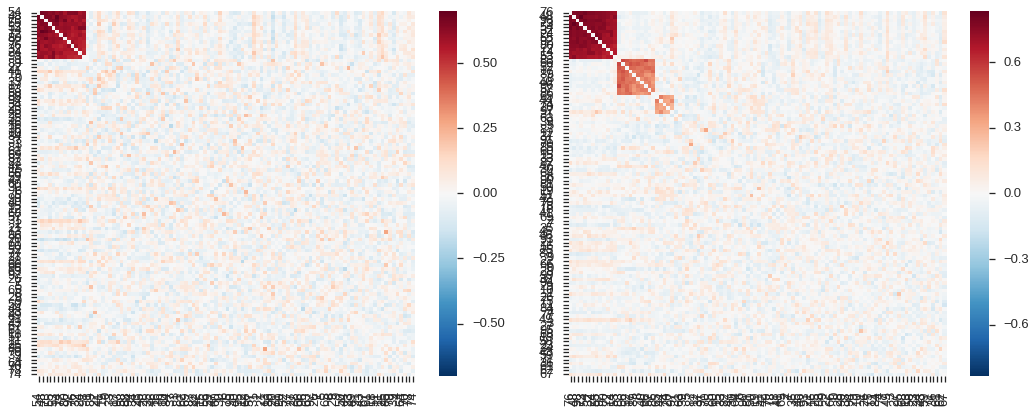

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

ordered_matrix_1 = corr_matrix_1[corr_order_1, :][:, corr_order_1]
ordered_matrix_2 = corr_matrix_2[corr_order_2, :][:, corr_order_2]

matstat.plot_matrix(ordered_matrix_1, ax[0], labels=corr_order_1, remove_autocorr=True)
matstat.plot_matrix(ordered_matrix_2, ax[1], labels=corr_order_2, remove_autocorr=True)